In [3]:
import ee
# ee.Authenticate()
service_account = 'ignaciomurillo97@round-gasket-183822.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, './round-gasket-183822-5ee7a3855b33.json')
ee.Initialize()

In [11]:
import requests
from PIL import Image
from io import BytesIO
from IPython.display import Image as IPyImage

apiKey = '46b34ce194a04492b68926a28c2a629f'
# Get static map from Geoapify
def get_static_map(lat, lon, zoom, width=500, height=500, scale=1, format='jpeg', api_key=apiKey):
    url = "https://api.geoapify.com/v1/staticmap"
    params = {
        "style": "osm-carto",
        "width": width,
        "height": height,
        "zoom": zoom,
        "center": f"lonlat:{lon},{lat}",
        "scale": scale,
        "format": format,
        "apiKey": api_key
    }
    response = requests.get(url, params=params)
    return response.content

# Generate Dataset

In [4]:
import random

def random_point_in_bounding_box(latlon1, latlon2):
    lat1, lon1 = latlon1
    lat2, lon2 = latlon2
    lat = random.uniform(lat1, lat2)
    lon = random.uniform(lon1, lon2)
    return (lat, lon)

In [5]:
from datetime import datetime

# coordinates = [(40.7128, -74.0060), (51.5074, -0.1278), (-33.8651, 151.2094)]
SAMPLES = 2000 
latlon1 = (-17.0357, 122.9197)
latlon2 = (-30.3538, 145.7713)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
drive_folder = f'GoogleEarthEngineExport'

coordinates = []
while len(coordinates) < SAMPLES:
  point = random_point_in_bounding_box(latlon1, latlon2)
  coordinates.append(point)

f"dirname: {drive_folder}, bounding box {latlon1, latlon2} ,coordinates: {coordinates}"


'dirname: GoogleEarthEngineExport, bounding box ((-17.0357, 122.9197), (-30.3538, 145.7713)) ,coordinates: [(-17.62823590669136, 144.77128148425535), (-25.923096602116615, 135.16819998473778), (-20.776374464796895, 127.5824381926835), (-23.8055166389971, 141.23926075410742), (-19.31611461100816, 139.4983136811962), (-17.715784110036868, 139.6436707910275), (-18.903365507482313, 142.81359679886873), (-20.84652641384368, 124.91568983117358), (-28.88246374782503, 137.85883854101147), (-27.428802408719086, 134.98063017222086), (-22.405889238689372, 134.12755966594673), (-28.427708002994443, 137.5579074616342), (-25.774633348920297, 127.59086845608945), (-19.498285106398953, 142.12790550198005), (-28.74060276323362, 143.0730994341446), (-21.659862104847825, 142.93129427199366), (-22.267882460829778, 131.54792833203456), (-28.370432088297598, 133.1042990441868), (-23.072703642600032, 133.9202440371022), (-25.82391522385374, 130.62348383588238), (-28.858307719072744, 131.28983327871754), (-28

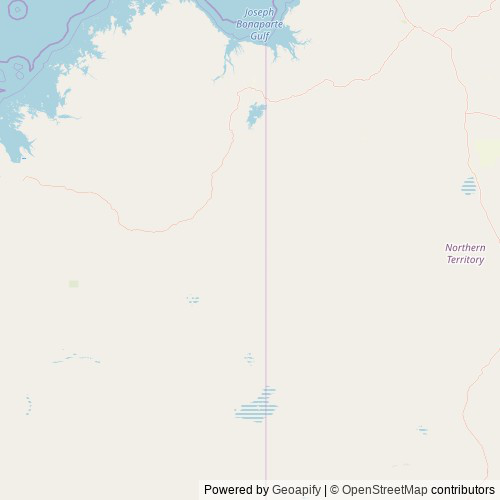

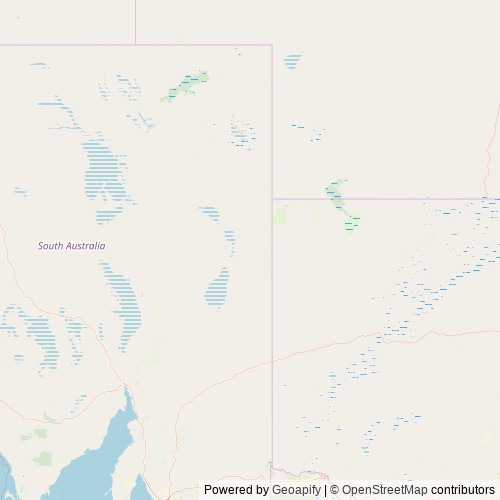

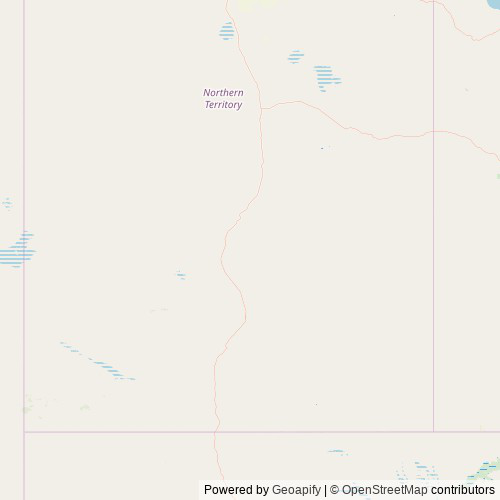

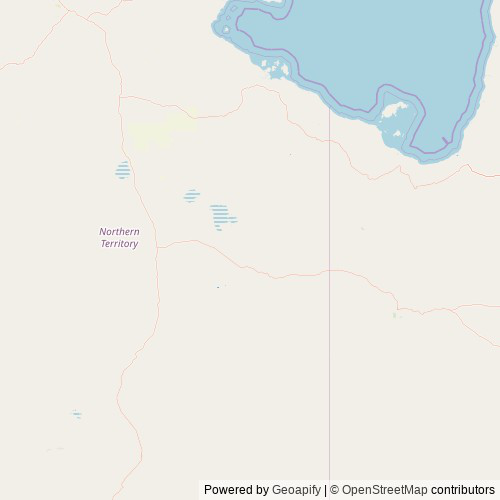

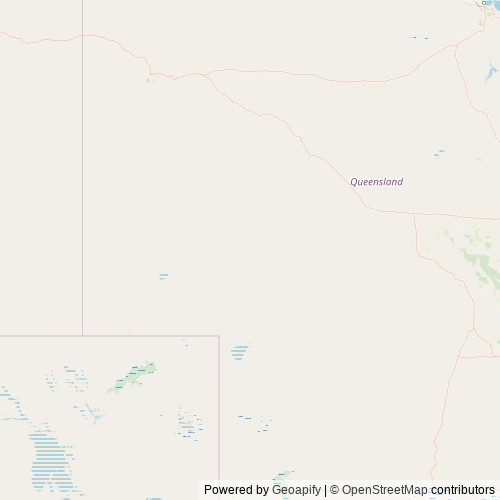

In [14]:
import time
# display static map of coordinates
for coordinate in coordinates:
  lat, lon = coordinate
  img = get_static_map(lat, lon, 5)
  img = Image.open(BytesIO(img))
  display(img)
  time.sleep(0.5)

In [7]:
def fetch_elevation(coordinates, folder, buffer):
    tasks = []
    
    # Loop over the list of coordinates
    for i, coord in enumerate(coordinates):
        # Extract the latitude and longitude from the coordinate tuple
        lat, lon = coord
        
        # Fetch the elevation data for the current coordinate
        region = ee.Geometry.BBox(lon - buffer, lat - buffer, lon + buffer, lat + buffer)
        elv_image = ee.Image('USGS/SRTMGL1_003').clip(region)
        
        # filename including coordinates
        # filename = f'projects/elevation/{i}/{lat:.4f}_{lon:.4f}_{ct.strftime("%Y%m%d_%H%M%S")}'.replace(".", "-")
        filename = f'elev_{i}_{lat}_{lon}_{ct.strftime("%Y%m%d_%H%M%S")}'
        # Create a task to export the image to Google Drive
        task = ee.batch.Export.image.toDrive(image=elv_image,
                                              description=f'elevation_{i}',
                                              folder=folder,
                                              fileNamePrefix=filename,
                                              region=elv_image.geometry().bounds().getInfo()['coordinates'],
                                              scale=10)

        # # task = ee.batch.Export.image.toAsset(
        # #                                       image=elv_image,
        # #                                       description=f'elevation_{i}',
        # #                                       assetId=filename,
        # #                                       region=elv_image.geometry().bounds().getInfo()['coordinates'],
        # #                                       scale=30)
        
        # Start the export task
        task.start()
        
        # Add the task to the list of tasks
        tasks.append(task)
    
    # Return the list of export tasks
    return tasks

In [6]:
import datetime
ct = datetime.datetime.now()

def export_region_around_coordinate(coordinates, folder, buffer):
    tasks = []
    
    # Loop over the list of coordinates
    for i, coord in enumerate(coordinates):
        latitude, longitude = coord
        # Define a point for the given coordinate
        point = ee.Geometry.Point([longitude, latitude])

        # Load the Sentinel-2 surface reflectance image collection for the date range of interest
        collection = ee.ImageCollection('COPERNICUS/S2_SR') \
            .filterBounds(point) \
            .filterDate('2020-01-01', '2020-12-31')

        # Filter out cloudy pixels
        # filteredCollection = collection \
        #     .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))

        # Select the first image in the filtered collection
        # image = filteredCollection.first()
        image = collection.first().select('B2')

        # Define the image export parameters
        filename = f'color_{i}_{latitude}_{longitude}_{ct.strftime("%Y%m%d_%H%M%S")}'
        export_params = {
            'image': image,
            'description':f'elevation_{i}',
            'AssetId':filename,
            'scale': 10,
            'region': point.buffer(buffer).bounds().getInfo()['coordinates'],
            'fileFormat': 'GeoTIFF',
            'folder': drive_folder,
            'skipEmptyTiles': True,
            'formatOptions': {
                'cloudOptimized': True
            }
        }

        # Export the image
        task = ee.batch.Export.image.toDrive(**export_params)
        task.start()
        tasks.append(task)
    return tasks

In [8]:
import time

# Fetch the elevation data for the coordinates and save them to Google Drive
print("creating fetch tests")
tasks = fetch_elevation(coordinates, drive_folder, 0.02)
print("fetch tasks created successfully")
# tasks.append(export_region_around_coordinate(coordinates, drive_folder, 10000))
# tasks = export_region_around_coordinate(coordinates, drive_folder, 10000)

# Wait for all the export tasks to complete
for task in tasks:
    print(f'Waiting for task {task.id} to complete...')
    while task.active():
        time.sleep(5)
    print(f'Task {task.id} completed with status {task.status()}')

print(f'all tasks completed!')

creating fetch tests
fetch tasks created successfully
Waiting for task ISW375PPOAM4YVKPBNKB4CGG to complete...
Task ISW375PPOAM4YVKPBNKB4CGG completed with status {'state': 'COMPLETED', 'description': 'elevation_0', 'creation_timestamp_ms': 1692070774972, 'update_timestamp_ms': 1692070788987, 'start_timestamp_ms': 1692070781652, 'task_type': 'EXPORT_IMAGE', 'destination_uris': ['https://drive.google.com/#folders/19gg-R1btK6xpWSYOwUrC6DG8MkfC-Nxh'], 'attempt': 1, 'batch_eecu_usage_seconds': 0.1454487293958664, 'id': 'ISW375PPOAM4YVKPBNKB4CGG', 'name': 'projects/earthengine-legacy/operations/ISW375PPOAM4YVKPBNKB4CGG'}
Waiting for task 4SF3E7O4BZMBJ7CABNDJPYDR to complete...
Task 4SF3E7O4BZMBJ7CABNDJPYDR completed with status {'state': 'COMPLETED', 'description': 'elevation_1', 'creation_timestamp_ms': 1692070776336, 'update_timestamp_ms': 1692070791628, 'start_timestamp_ms': 1692070781686, 'task_type': 'EXPORT_IMAGE', 'destination_uris': ['https://drive.google.com/#folders/19gg-R1btK6xpW